In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_csv('../input/brazilian-ecommerce/olist_order_reviews_dataset.csv')


In [3]:
df.describe()

,review_score
count,100000.000000
mean,4.070890
std,1.359663
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [4]:
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [5]:
df.pop('review_comment_title')
df.pop('review_id')
df.pop('order_id')

0        73fc7af87114b39712e6da79b0a377eb
1        a548910a1c6147796b98fdf73dbeba33
2        f9e4b658b201a9f2ecdecbb34bed034b
3        658677c97b385a9be170737859d3511b
4        8e6bfb81e283fa7e4f11123a3fb894f1
                       ...               
99995    22ec9f0669f784db00fa86d035cf8602
99996    55d4004744368f5571d1f590031933e4
99997    7725825d039fc1f0ceb7635e3f7d9206
99998    f8bd3f2000c28c5342fedeb5e50f2e75
99999    90531360ecb1eec2a1fbb265a0db0508
Name: order_id, Length: 100000, dtype: object

In [6]:
df.head()

,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,4,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,5,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,5,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [7]:
df.describe()

,review_score
count,100000.000000
mean,4.070890
std,1.359663
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


# Cleaning the dataset
* What we are going to do :
    * Remove where there are no comments 
    * Show how much data did we lost 

In [8]:
n_of_r = df['review_comment_message'].isnull().sum()
print(f'N of rows without comments : {n_of_r}')
print(f'N of rows with comments: {len(df)-n_of_r}')

N of rows without comments : 58247
N of rows with comments: 41753


In [9]:
df =df.dropna() 

In [10]:
y = df.pop('review_score') 

In [11]:
df

,review_comment_message,review_creation_date,review_answer_timestamp
3,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
...,...,...,...
99983,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23
99990,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06
99996,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99998,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


# Distibution of reviews
* Does the data is very sparse ? 
* Is the data concentrated ?

* We can see that the data is concentrated around the 5 star review and the 1 star review. 
* We are going to balance this data

<AxesSubplot:>

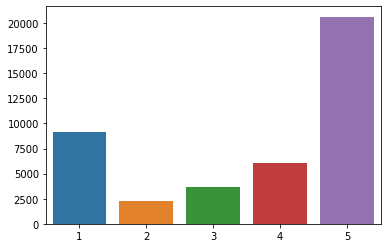

In [12]:
sns.barplot(x = np.unique(y), y = [list(y).count(i) for i in np.unique(y)])

In [13]:
for i in np.unique(y):
    print(f'The percentage of {i} in the data is {list(y).count(i)/len(df)} %')

The percentage of 1 in the data is 0.21984049050367638 %
The percentage of 2 in the data is 0.053385385481282785 %
The percentage of 3 in the data is 0.08777812372763634 %
The percentage of 4 in the data is 0.14451656168419036 %
The percentage of 5 in the data is 0.49447943860321414 %


# Pre Processing the text data 
* What are we going to do ?
    * Take the text and remove any kinds of special characters
    * Remove portuguese stopwords from the text
    * Lemmatize the words
    * Show the words inside the dataset with word clouds
    * Then we are going to use BagOfWords to create the vectors later we aregoing to use TF-IDF.

In [14]:
texts = df['review_comment_message']

In [15]:
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(texts))

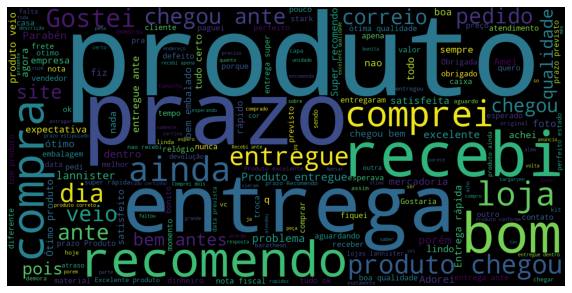

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud)

In [18]:
def pre_process_data(text):
    lemm = WordNetLemmatizer()
    text  = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    tokenized = word_tokenize(text)
    text = [lemm.lemmatize(i.lower()) for i in tokenized if not(i.lower() in stop_words) and i.isalpha()]
    return ' '.join(text)

In [19]:
texts = [pre_process_data(i) for i in texts]

In [20]:
vectorizer = CountVectorizer(max_features=10000)
vectorizer2 = TfidfTransformer()
x = vectorizer.fit_transform(texts)
x = vectorizer2.fit_transform(x,y)

# Building the model without oversampling 

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x,y)
rf_model = RandomForestClassifier(n_jobs=5,verbose=1)

In [22]:
scores_nos = cross_val_score(rf_model,x,y)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   20.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   45.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   17.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   41.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   17.7s
[Parallel(n_jobs=5)]: Done 100

In [23]:
print(f'The Average score for not oversampled data is {scores_nos.mean()}')

The Average score for not oversampled data is 0.6649341403410399


In [24]:
rf_model.fit(x_train,y_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   16.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   38.0s finished


RandomForestClassifier(n_jobs=5, verbose=1)

In [25]:
y_pred = rf_model.predict(x_test)
print(classification_report(y_test,y_pred))

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           1       0.61      0.89      0.72      2297
           2       0.45      0.05      0.09       549
           3       0.34      0.06      0.10       927
           4       0.34      0.07      0.12      1507
           5       0.73      0.92      0.81      5159

    accuracy                           0.67     10439
   macro avg       0.49      0.40      0.37     10439
weighted avg       0.59      0.67      0.59     10439



[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished


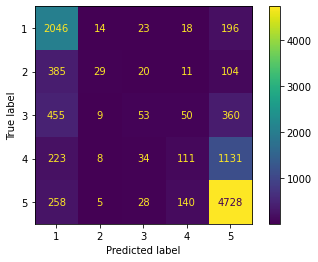

In [26]:
plot_confusion_matrix(rf_model,x_test,y_test)

# Oversampling

We will oversample the data so wich class can have the same amount of vectors as the biggest class this happens mainly because the 5 class. 

In [27]:
ro = RandomOverSampler()
x_ros, y_ros = ro.fit_resample(x, y)
x_train,x_test,y_train,y_test = train_test_split(x_ros,y_ros)

<AxesSubplot:>

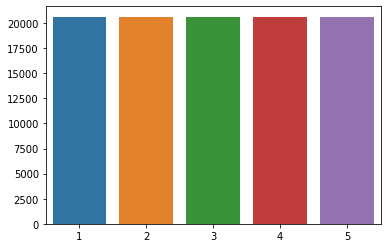

In [28]:
sns.barplot(x = np.unique(y), y = [list(y_ros).count(i) for i in np.unique(y)])

In [29]:
rf_model = RandomForestClassifier(verbose = 1,n_jobs=5)
score = cross_val_score(rf_model,x_ros,y_ros,cv=5)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   42.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   41.8s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   42.8s
[Parallel(n_jobs=5)]: Done 100

In [30]:
print(f'The mean score was: {score.mean()}')

The mean score was: 0.8890826310181149


In [31]:
rf_model.fit(x_train,y_train)
y_pred = rf_model.predict(x_test)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   41.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.7s finished


In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.91      0.94      0.92      5190
           2       0.95      0.96      0.96      5092
           3       0.94      0.88      0.90      5229
           4       0.77      0.85      0.81      5190
           5       0.84      0.77      0.80      5107

    accuracy                           0.88     25808
   macro avg       0.88      0.88      0.88     25808
weighted avg       0.88      0.88      0.88     25808



[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.6s finished


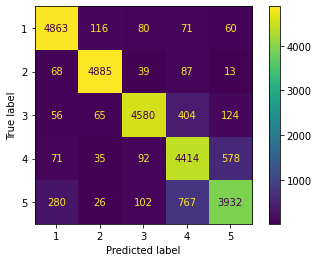

In [33]:
plot_confusion_matrix(rf_model,x_test,y_test)

# Conclusion 1 
* Is this result what we expected?
    * Really this result brings suspicious thoughts about the quality of the model oversampled mainly by it's high accuracy with multiple classes 
    * This means that we can be having a data leakage. If you can point out what is happening in the comments or if you think it's a normal result leave the comment below 
    * Actually i personally believe that by oversampling we are actually overfiting our model, making it falsely having greater precision, mainly because the training data and the test data share, by the overfitting, the same data, making the model highly specific from the data that we gave it but should perform worst in new data when showed.

# What if we classified as good or bad ?
* We are going to put any comment with an 4+ review as a good comment and else a bad comment
* We can see by the model below that the class that had the biggest mistakes is the 4 to 5 and 5 to 4 predictions what will happen if we join this both classes ?
* Will we have a better result ?

In [34]:
y[y<4] = 0 #setting to be bad 1,2,3
y[y>3] = 1 # setting to be good 4 and 5 

is the data balanced or close to it ?

In [35]:
perc = list(y).count(1)/len(y)
print(f'The percentage of good comments is {perc}')
print(f'The percentaage of bad comments is {1-perc}')

The percentage of good comments is 0.6389960002874046
The percentaage of bad comments is 0.36100399971259545


i believe is balanced the difference is not that huge

In [36]:
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [37]:
score = cross_val_score(rf_model,x_train,y_train,cv=5)
print(f'Average score is {score.mean()}')
rf_model.fit(x_train,y_train)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   18.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 100

Average score is 0.873315318892373


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.8s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   24.1s finished


RandomForestClassifier(n_jobs=5, verbose=1)

In [38]:
y_pred = rf_model.predict(x_test)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished


In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      3787
           1       0.90      0.90      0.90      6652

    accuracy                           0.87     10439
   macro avg       0.86      0.86      0.86     10439
weighted avg       0.87      0.87      0.87     10439



[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished


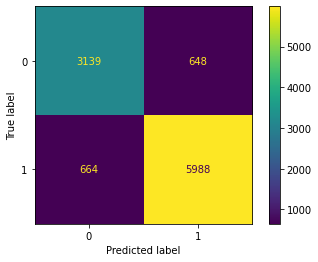

In [40]:
plot_confusion_matrix(rf_model,x_test,y_test)

# Conclusion - Final 
* What did we made it ?
    * First we made an small analysis of the  data to see how the classes are organized 
    * Second we pre-processed the text data and shown the word cloud representation of the data 
    * Later we Oversampled the data so all the classes have the same amount in the training and testing data
    * We saw the cross validation mean score for the dataset oversampled, not oversampled and showing our suspicious thoughts on the model when its oversampled.
    * Then we worked on making the result data binary and simpler for a model to understand
    * We got better results usng the binary classification than the multiple class, i think we need to disconsider the oversampled model mainly because the training data and the test data share data what is problematic.
    
**Thank you for reading the notebook if you enjoyed please leave a comment and give it an up on the notebook**